# Check su modello creato

In [1]:
#Per prima cosa importiamo tutto ciò di cui abbiamo bisogno
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import keras.backend
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import SGD
from numpy.random import seed
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score
import copy
import matplotlib.pyplot as plt
import theano.tensor as T
import seaborn as sns
from bioinformatics_helpers.utils import interpolated_precision_recall_curve as pr_curve

Using Theano backend.


In [14]:
def plot_pr_curve_probas_histogram(probas_pred, y_true):
    p,r,t = precision_recall_curve(probas_pred=probas_pred, y_true=y_true, pos_label=1)
    f, (ax1, ax2) = plt.subplots(2,sharex=False, sharey=False, gridspec_kw={"hspace":1})

    fig_test = plt.figure()
    ax1.axis([0, 1, 0, 1])
    ax1.set_xlabel("Recall")
    ax1.set_ylabel("Precision")
    ax1.set_title("PR Curve")
    r1,p1 = pr_curve(y_prob=probas_pred, y_true=y_true)
    ax1.plot(r1,p1)
    bins = np.linspace(0,1,10)

    ax2.hist(y_true,bins,alpha=0.8)
    ax2.set_title('Model output distribution')
    print("AUPRC: ", np.round(auc(x=r,y=p),decimals=3))
    print("AUROC: ", np.round(roc_auc_score(y_score=probas_pred, y_true=y_true),decimals=3))
    print("Avg prec score: ", average_precision_score(y_score=probas_pred, y_true=y_true))
    plt.show()

In [15]:
def print_stats_on_predictions(positives_probas, negatives_probas):
    print("positive class probas mean: {:.2f}, std: {:.2f}"
          .format(
              np.mean(positives_probas),
              np.std(positives_probas)
          )
         )
    print("negative class probas mean: {:.2f}, std: {:.2f}"
          .format(
              np.mean(negatives_probas),
              np.std(negatives_probas)
          )
         )
    #get iqr range
    q1_q3 = np.percentile(positives_probas, [25,75])
    iqr = q1_q3[1] - q1_q3[0]
    bottom_value = q1_q3[0] - (1.5 * iqr)
    high_value = q1_q3[1] + (1.5 * iqr)

    #high outliers in negative class
    negative_class_outliers = negatives_probas[negatives_probas > bottom_value]
    print("number of negative outliers, prob > {:.3f}: {}".format(bottom_value,len(negative_class_outliers)))


### Get dataset

In [ ]:
base_data_folder = "/home/alessio/dati/"
train_set_filename = base_data_folder + "Mendelian.train.tsv"
test_set_filename = base_data_folder + "Mendelian.test.tsv"

train_X = pd.read_csv(train_set_filename, sep='\t').values
test_X = pd.read_csv(test_set_filename, sep='\t').values
#creiamo le label, nel train set i primi 356 esempi sono positivi, nel test i primi 40 sono positivi
n_positives = 356
n_negatives = train_X.shape[0] - n_positives
train_y = np.concatenate((
    np.ones(n_positives, dtype=np.int32),
    np.zeros(n_negatives, dtype=np.int32)
))
n_positives = 40
n_negatives = test_X.shape[0] - n_positives
test_y = np.concatenate((
    np.ones(n_positives, dtype=np.int32),
    np.zeros(n_negatives, dtype=np.int32)
))
feature_per_example=26
batch_size = 500
my_seed = 2024 #imposto un valore di seed da dare a tutti i generatori
seed(my_seed) #seed numpy

### Loading model 

In [5]:
def hingesig(y_true, y_pred):
    transform_y_true = T.switch(T.eq(y_true,0), -1, y_true)
    clipped_y_pred = T.clip(y_pred, 1e-20, 0.9999999)
    logit = (T.log2(clipped_y_pred) - T.log2(T.sub(1., clipped_y_pred)))
    return T.mean(T.maximum(1. - transform_y_true * logit, 0.), axis=-1)

def create_model(loss='binary_crossentropy', activation='tanh'):
    model = Sequential()
    initializer = keras.initializers.glorot_uniform(seed=my_seed)
    model.add(Dense(
            300, 
            input_dim=feature_per_example, 
            kernel_initializer=initializer,
            activation=activation)
             )
    model.add(Dense(
            1,
            kernel_initializer=initializer,
            activation='sigmoid'
    ))
    optimizer = SGD(lr=0.01, decay=0, momentum=0, nesterov=False)
    model.compile(loss=loss, optimizer=optimizer)
    return model

best_model = joblib.load("best_estimator.pkl")

# Plotting PR curve and output probabilities distribution on the test set

19018/19018 [==============================] - 0s 12us/step
AUPRC:  0.074
AUROC:  0.968
Avg prec score:  0.08042488047329936


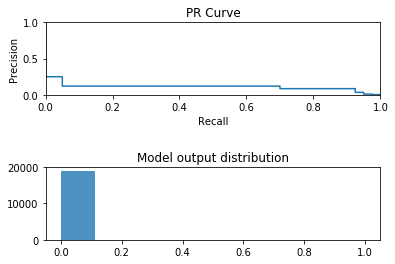

<Figure size 432x288 with 0 Axes>

In [22]:
best_model_probas = best_model.predict_proba(test_X)[:,1]
plot_pr_curve_probas_histogram(best_model_probas, test_y)


positive class probas mean: 0.26, std: 0.04
negative class probas mean: 0.13, std: 0.04
number of negative outliers, prob > 0.244: 500


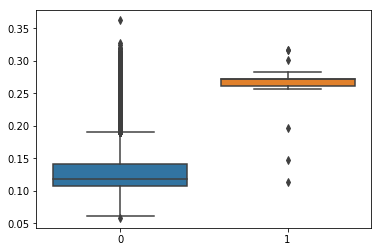

In [23]:
test_probas_positives = best_model_probas[:40]
test_probas_negatives = best_model_probas[40:]
print_stats_on_predictions(test_probas_positives, test_probas_negatives)
data=[test_probas_negatives, test_probas_positives]
ax = sns.boxplot(data=data)

# Plotting PR curve and output probabilities distribution on the training set

981388/981388 [==============================] - 14s 15us/step
AUPRC:  0.11
AUROC:  0.956
Avg prec score:  0.11179578477682536


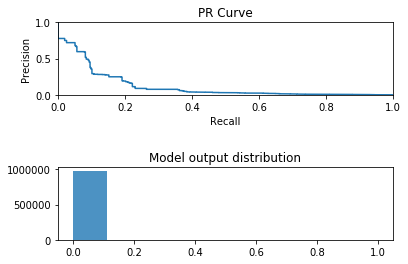

<Figure size 432x288 with 0 Axes>

In [25]:
best_model_train_probas = best_model.predict_proba(train_X)[:,1]
plot_pr_curve_probas_histogram(best_model_train_probas, y_true=train_y)

positive class probas mean: 0.26, std: 0.04
negative class probas mean: 0.13, std: 0.04
number of negative outliers, prob > 0.244: 500


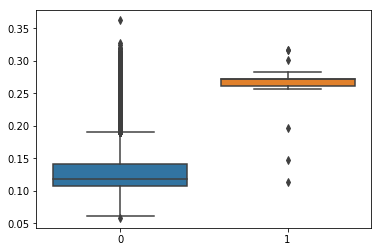

In [26]:
train_probas_positives = best_model_train_probas[:356]
train_probas_negatives = best_model_train_probas[356:]
print_stats_on_predictions(test_probas_positives, test_probas_negatives)
data=[test_probas_negatives, test_probas_positives]
ax = sns.boxplot(data=data)